# Agent Chat with Multimodal Models: GPT-4V

### Before everything starts, install AutoGen with the `lmm` option
```bash
pip install "pyautogen[lmm]~=0.2.0b4"
```

In [1]:
!pip install "pyautogen[lmm]~=0.2.0b4"

In [2]:
import requests
import json
import os

from typing import Any, Callable, Dict, List, Optional, Tuple, Type, Union

import autogen
from autogen import AssistantAgent, Agent, UserProxyAgent, ConversableAgent
from termcolor import colored
import random

<a id="app-1"></a>
## Application 1: Image Chat

In this section, we present a straightforward dual-agent architecture to enable user to chat with a multimodal agent.


First, we show this image and ask a question.
![](https://th.bing.com/th/id/R.422068ce8af4e15b0634fe2540adea7a?rik=y4OcXBE%2fqutDOw&pid=ImgRaw&r=0)

Within the user proxy agent, we can decide to activate the human input mode or not (for here, we use human_input_mode="NEVER" for conciseness). This allows you to interact with LMM in a multi-round dialogue, enabling you to provide feedback as the conversation unfolds.

In [3]:
from autogen.agentchat.contrib.multimodal_conversable_agent import MultimodalConversableAgent

config_list_4v = autogen.config_list_from_json(
    "../OAI_CONFIG_LIST",
    filter_dict={
        "model": ["gpt-4-vision-preview"],
    },
)

config_list_gpt4 = autogen.config_list_from_json(
    "../OAI_CONFIG_LIST",
    filter_dict={
        "model": ["gpt-4", "gpt-4-0314", "gpt4", "gpt-4-32k", "gpt-4-32k-0314", "gpt-4-32k-v0314"],
    },
)

gpt4_llm_config = {"config_list": config_list_gpt4, "cache_seed": 42}

In [4]:
# Remove the `api_type` param as it is not needed for 4V
[config.pop("api_type", None) for config in config_list_4v]

[None]

In [4]:
# image_agent._oai_messages[user_proxy]

In [5]:
image_agent = MultimodalConversableAgent(
    name="image-explainer",
    max_consecutive_auto_reply=10,
    llm_config={"config_list": config_list_4v, "temperature": 0.5, "max_tokens": 300}
)

user_proxy = autogen.UserProxyAgent(
    name="User_proxy",
    system_message="A human admin.",
    human_input_mode="NEVER", # Try between ALWAYS or NEVER
    max_consecutive_auto_reply=0
)

# Ask the question with an image
user_proxy.initiate_chat(image_agent, 
                         message="""What's the breed of this dog? 
<img https://th.bing.com/th/id/R.422068ce8af4e15b0634fe2540adea7a?rik=y4OcXBE%2fqutDOw&pid=ImgRaw&r=0>.""")

User_proxy (to image-explainer):

What's the breed of this dog? 
<image>.

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
image-explainer (to User_proxy):

The dog in the image appears to be a Goldendoodle. This breed is a cross between a Golden Retriever and a Poodle, known for its curly or wavy coat and friendly disposition. They come in various sizes depending on the Poodle parent (Standard, Miniature, or Toy), and their coats can range in color from cream to golden to red.

--------------------------------------------------------------------------------


Now, input another image, and ask a followup question.

![](https://th.bing.com/th/id/OIP.29Mi2kJmcHHyQVGe_0NG7QHaEo?pid=ImgDet&rs=1)

In [6]:
# Ask the question with an image
user_proxy.send(message="""What is this breed? 
<img https://th.bing.com/th/id/OIP.29Mi2kJmcHHyQVGe_0NG7QHaEo?pid=ImgDet&rs=1>

Among the breeds, which one barks less?""", 
                recipient=image_agent)

User_proxy (to image-explainer):

What is this breed? 
<image>

Among the breeds, which one barks less?

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
image-explainer (to User_proxy):

The dog in the image is a Siberian Husky, identifiable by its thick fur, erect triangular ears, and distinctive markings.

Between the Goldendoodle and the Siberian Husky, the Husky is generally known to bark less. Huskies are often more prone to howling rather than barking, and while they can be vocal, they are not typically barkers. Goldendoodles can vary in their barking habits, as it can depend on the traits they inherit from their Golden Retriever and Poodle parents. However, any dog's tendency to bark will be influenced by individual personality, training, environment, and how they are socialized.

--------------------------------------------------------------------------------


<a id="app-2"></a>
## Application 2: Figure Creator

Here, we define a `FigureCreator` agent, which contains three child agents: commander, coder, and critics.

- Commander: interacts with users, runs code, and coordinates the flow between the coder and critics.
- Coder: writes code for visualization.
- Critics: LMM-based agent that provides comments and feedback on the generated image.

In [7]:
class FigureCreator(AssistantAgent):

    def __init__(self, n_iters=2, **kwargs):
        """
        Initializes a FigureCreator instance.
        
        This agent facilitates the creation of visualizations through a collaborative effort among its child agents: commander, coder, and critics.
        
        Parameters:
            - n_iters (int, optional): The number of "improvement" iterations to run. Defaults to 2.
            - **kwargs: keyword arguments for the parent AssistantAgent.
        """
        super().__init__(**kwargs)
        self.register_reply([Agent, None],
                            reply_func=FigureCreator._reply_user,
                            position=0)
        self._n_iters = n_iters

    def _reply_user(self, messages=None, sender=None, config=None):
        if all((messages is None, sender is None)):
            error_msg = f"Either {messages=} or {sender=} must be provided."
            logger.error(error_msg)
            raise AssertionError(error_msg)

        if messages is None:
            messages = self._oai_messages[sender]

        user_question = messages[-1]["content"]

        ### Define the agents
        commander = AssistantAgent(
            name="Commander",
            human_input_mode="NEVER",
            max_consecutive_auto_reply=10,
            system_message=
            "Help me run the code, and tell other agents it is in the <img result.jpg> file location.",
            is_termination_msg=lambda x: x.get("content", "").rstrip().endswith(
                "TERMINATE"),
            code_execution_config={
                "last_n_messages": 3,
                "work_dir": ".",
                "use_docker": False
            },
            llm_config=self.llm_config,
        )

        critics = MultimodalConversableAgent(
            name="Critics",
            system_message=
            """Criticize the input figure. How to replot the figure so it will be better? Find bugs and issues for the figure. 
            Pay attention to the color, format, and presentation. Keep in mind of the reader-friendliness.
            If you think the figures is good enough, then simply say NO_ISSUES""",
            llm_config={"config_list": config_list_4v, "max_tokens": 300},
            human_input_mode="NEVER",
            max_consecutive_auto_reply=1,
            #     use_docker=False,
        )

        coder = AssistantAgent(
            name="Coder",
            llm_config=self.llm_config,
        )

        coder.update_system_message(
            coder.system_message +
            "ALWAYS save the figure in `result.jpg` file. Tell other agents it is in the <img result.jpg> file location."
        )

        # Data flow begins
        commander.initiate_chat(coder, message=user_question)
        img = Image.open("result.jpg")
        plt.imshow(img)
        plt.axis('off')  # Hide the axes
        plt.show()
        
        for i in range(self._n_iters):
            commander.send(message="Improve <img result.jpg>",
                           recipient=critics,
                           request_reply=True)
            
            feedback = commander._oai_messages[critics][-1]["content"]
            if feedback.find("NO_ISSUES") >= 0:
                break
            commander.send(
                message="Here is the feedback to your figure. Please improve! Save the result to `result.jpg`\n"
                + feedback,
                recipient=coder,
                request_reply=True)
            img = Image.open("result.jpg")
            plt.imshow(img)
            plt.axis('off')  # Hide the axes
            plt.show()
            
        return True, "result.jpg"

User (to Figure Creator~):


Plot a figure by using the data from:
https://raw.githubusercontent.com/vega/vega/main/docs/data/seattle-weather.csv

I want to show both temperature high and low.


--------------------------------------------------------------------------------
Commander (to Coder):


Plot a figure by using the data from:
https://raw.githubusercontent.com/vega/vega/main/docs/data/seattle-weather.csv

I want to show both temperature high and low.


--------------------------------------------------------------------------------
Coder (to Commander):

Alright, to perform this task, we will use pandas to read the data, and matplotlib to generate the plot. Here is the python code to do this.

```python
import pandas as pd
import matplotlib.pyplot as plt

# Read the data
data = pd.read_csv('https://raw.githubusercontent.com/vega/vega/main/docs/data/seattle-weather.csv')

# Convert date from string to datetime
data['date'] = pd.to_datetime(data['date'])

# Generate the plot
plt

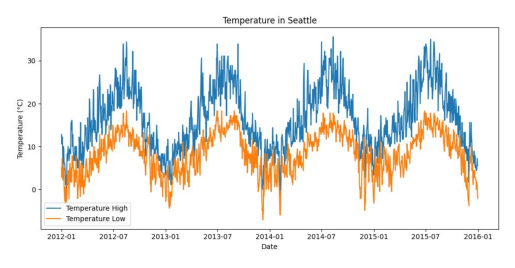

Commander (to Critics):

Improve <image>

--------------------------------------------------------------------------------
Critics (to Commander):

The figure presents a time series plot of temperature highs and lows in Seattle. Here are some suggestions for improvement:

1. **Axis Labels**: Increase the font size of the axis labels ("Temperature (°C)" and "Date") to improve readability.

2. **Data Density**: The plot appears to be very dense, potentially with daily data points that make the chart look cluttered. Consider plotting weekly or monthly averages if the intention is to show longer-term trends.

3. **Legend**: The legend is covering part of the data. It could be moved to a better location, such as the top left corner or outside the plot area, to ensure it doesn't obscure any data.

4. **Gridlines**: Adding horizontal gridlines could help in reading the temperature values across the chart more easily.

5. **Color Contrast**: Ensure there is enough contrast between the two line

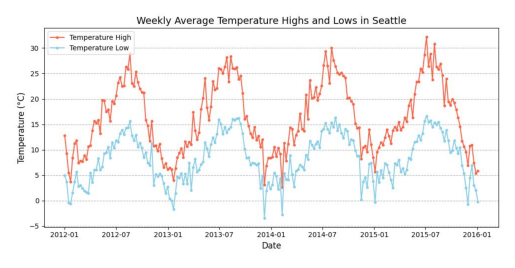

Commander (to Critics):

Improve <image>

--------------------------------------------------------------------------------
Commander (to Coder):

Here is the feedback to your figure. Please improve! Save the result to `result.jpg`
Improve <img result.jpg>

--------------------------------------------------------------------------------
Coder (to Commander):

I apologize but without specific feedback, it's hard to know exactly what needs to be improved in the figure. However, based on common best practices for creating effective graphs, I can suggest a few adjustments:

1. Add a background color to increase readability.
2. Use a more contrasting color scheme for better visibility.
3. Include more clear and detailed labels.
4. Add a subtitle to provide more information about the data.
5. Increase line thickness for more visibility.

Here is the improved Python code to include these suggestions:

```python
import pandas as pd
import matplotlib.pyplot as plt

# Read the data
data = pd.read

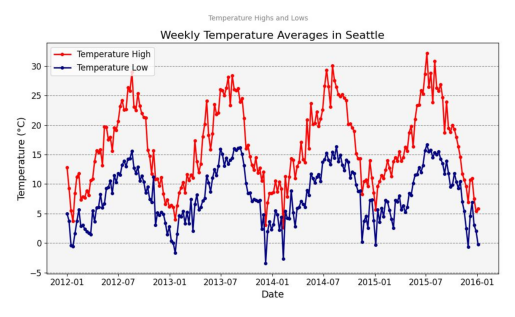

Figure Creator~ (to User):

result.jpg

--------------------------------------------------------------------------------


In [8]:
import matplotlib.pyplot as plt
import time
from PIL import Image


# config_list_gpt35 = autogen.config_list_from_json(
#     "OAI_CONFIG_LIST",
#     filter_dict={
#         "model": ["gpt-35-turbo", "gpt-3.5-turbo"],
#     },
# )

# gpt35_llm_config = {"config_list": config_list_gpt35, "cache_seed": 42}


creator = FigureCreator(
    name="Figure Creator~",
    llm_config=gpt4_llm_config
    
)

user_proxy = autogen.UserProxyAgent(
    name="User",
    human_input_mode="NEVER",
    max_consecutive_auto_reply=0
)

user_proxy.initiate_chat(creator, message="""
Plot a figure by using the data from:
https://raw.githubusercontent.com/vega/vega/main/docs/data/seattle-weather.csv

I want to show both temperature high and low.
""")


In [9]:
if os.path.exists("result.jpg"):
    os.remove("result.jpg") # clean up